# Random SSM
This notebook trains a Random SSM on sin(x) or sin(ax+b) sequences. 
The hyperparameters are defined in the `config.yaml` file. 
- N (hidden state dimension): 64
- H (d_model in yaml, number of heads): 10

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from data import create_sin_ax_b_dataset
from model import BatchStackedModel, SSMLayer
import torch
from utils import cross_entropy_loss, compute_accuracy
from tqdm import tqdm

In [2]:
rng = jax.random.PRNGKey(1)

In [5]:
from omegaconf import OmegaConf

# load the configuration file
cfg = OmegaConf.load("config.yaml")

In [6]:
dataset = cfg.dataset  # str
layer = cfg.layer  # str
seed  = cfg.seed  # int
model = cfg.model  # DictConfig
train = cfg.train  # DictConfig

In [7]:
# Set randomness...
print("[*] Setting Randomness...")
torch.random.manual_seed(seed)  # For dataloader order
key = jax.random.PRNGKey(seed)
key, rng, train_rng = jax.random.split(key, num=3) # TODO: This is bad 


[*] Setting Randomness...


In [8]:
# Check if classification dataset
# because for each dataset there are two versions, eg: mnist and mnist-classification
# TODO: in our case, sin x dataset is not a classification dataset
# classification = "classification" in dataset
classification = False
print(f'{classification=}')

create_dataset_fn = create_sin_ax_b_dataset
trainloader, testloader, n_classes, l_max, d_input, data = create_dataset_fn(bsz=train.bsz)
print(f'{n_classes=}, {l_max=}, {d_input=}')

print(f'{next(iter(trainloader))[0].shape=}')
print(f'{next(iter(testloader))[0].shape=}')

classification=False
[*] Generating sin(ax + b) Dataset...
	=>> Generating 2000 Training Examples...


100%|██████████| 2000/2000 [00:00<00:00, 8236.55it/s]


	=>> Generating 128 Test Examples...


100%|██████████| 128/128 [00:00<00:00, 9380.61it/s]

n_classes=8, l_max=16, d_input=1
next(iter(trainloader))[0].shape=torch.Size([128, 16, 1])
next(iter(testloader))[0].shape=torch.Size([128, 16, 1])


In [9]:
layer_cls = SSMLayer

In [10]:
model.layer.l_max = l_max # l_max comes from the dataset fn

In [11]:
# getattr returns the value of the named attribute of an object. 
# If not found, it returns the default value provided to the function.
lr_layer = getattr(layer_cls, "lr", None)  # lr_layer should be a dictionary
print(f'{lr_layer=} (if None, means that the attribute is not found)')

lr_layer=None (if None, means that the attribute is not found)


In [12]:
from functools import partial

print(f"[*] Starting `{layer}` Training on `{dataset}` =>> Initializing...")

# partial: Return a new partial object which when called will behave like func called with the positional arguments args and keyword arguments keywords.
# a partial object is a wrapper for a callable object. The partial object can be called as though it is the wrapped callable object.
model_cls = partial(
        BatchStackedModel,
        layer_cls=layer_cls,
        d_output=n_classes,
        classification=classification,
        **model,
    )

[*] Starting `s4` Training on `mnist-classification` =>> Initializing...


In [13]:
import optax
from flax.training import train_state


# TODO: go to create_train_state function (and skip this mapping) it's just a helper function
# As we're using Flax, we also write a utility function to return a default TrainState object.
# This function initializes model parameters, as well as our optimizer. Note that for S4 models,
# we use a custom learning rate for parameters of the S4 kernel (lr = 0.001, no weight decay).
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(nested_dict):
        return {
            k: (map_fn(v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }

    return map_fn
def create_train_state(
    rng,
    model_cls,
    trainloader,
    lr=1e-3,
    lr_layer=None,
    lr_schedule=False,
    weight_decay=0.0,
    total_steps=-1,
):
    print(f'[*] Creating Train State...')
    model = model_cls(training=True)
    init_rng, dropout_rng = jax.random.split(rng, num=2)
    print(f'Init')
    params = model.init(
        {"params": init_rng, "dropout": dropout_rng},
        jnp.array(next(iter(trainloader))[0].numpy()),
    )
    # Note: Added immediate `unfreeze()` to play well w/ Optax. See below!
    # params = params["params"].unfreeze() # TODO: i commented this line out because I got an error "'dict' object has no attribute 'unfreeze'"

    # Handle learning rates:
    # - LR scheduler
    # - Set custom learning rates on some SSM parameters

    # Note for Debugging... this is all undocumented and so weird. The following links are helpful...
    #
    #   > Flax "Recommended" interplay w/ Optax (this bridge needs ironing):
    #       https://github.com/google/flax/blob/main/docs/flip/1009-optimizer-api.md#multi-optimizer
    #
    #   > But... masking doesn't work like the above example suggests!
    #       Root Explanation: https://github.com/deepmind/optax/issues/159
    #       Fix: https://github.com/deepmind/optax/discussions/167
    #
    #   > Also... Flax FrozenDict doesn't play well with rest of Jax + Optax...
    #       https://github.com/deepmind/optax/issues/160#issuecomment-896460796
    #
    #   > Solution: Use Optax.multi_transform!
    print(f'LRschedule')
    if lr_schedule:
        schedule_fn = lambda lr: optax.cosine_onecycle_schedule(
            peak_value=lr,
            transition_steps=total_steps,
            pct_start=0.1,
        )
    else:
        schedule_fn = lambda lr: lr
    # lr_layer is a dictionary from parameter name to LR multiplier
    if lr_layer is None:
        lr_layer = {}

    optimizers = {
        k: optax.adam(learning_rate=schedule_fn(v * lr))
        for k, v in lr_layer.items()
    } # TODO: in our case this will be an empty dictionary
    # Add default optimizer
    # Note: it would be better to use a dummy key such as None that can't conflict with parameter names,
    # but this causes a hard-to-trace error; it seems that the transforms keys list is being sorted inside optax.multi_transform
    # which causes an error since None can't be compared to str
    optimizers["__default__"] = optax.adamw(
        learning_rate=schedule_fn(lr),
        weight_decay=weight_decay,
    )
    name_map = map_nested_fn(lambda k, _: k if k in lr_layer else "__default__")
    tx = optax.multi_transform(optimizers, name_map)
    # TODO: there should be a way to get rid of these cumbersome lines in our simple sin x dataset case
    # For debugging, this would be the default transform with no scheduler or special params
    # tx = optax.adamw(learning_rate=lr, weight_decay=0.01)

    # Check that all special parameter names are actually parameters
    extra_keys = set(lr_layer.keys()) - set(jax.tree_leaves(name_map(params)))
    assert (
        len(extra_keys) == 0
    ), f"Special params {extra_keys} do not correspond to actual params"

    # Print parameter count
    _is_complex = lambda x: x.dtype in [jnp.complex64, jnp.complex128]
    param_sizes = map_nested_fn(
        lambda k, param: param.size * (2 if _is_complex(param) else 1)
        if lr_layer.get(k, lr) > 0.0
        else 0
    )(params)
    print(f"[*] Trainable Parameters: {sum(jax.tree_leaves(param_sizes))}")
    print(f"[*] Total training steps: {total_steps}")

    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )


In [14]:
state = create_train_state(
    rng=rng,
    model_cls=model_cls,
    trainloader=trainloader,
    lr=train.lr,
    lr_layer=lr_layer,
    lr_schedule=train.lr_schedule,
    weight_decay=train.weight_decay,
    total_steps=len(trainloader) * train.epochs,
)

[*] Creating Train State...
Init
LRschedule
[*] Trainable Parameters: 497788
[*] Total training steps: 1500


/var/folders/th/_3y3_jmx0mj98ffdxdh9fjt80000gn/T/ipykernel_42044/1457100967.py:88: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  extra_keys = set(lr_layer.keys()) - set(jax.tree_leaves(name_map(params)))
/var/folders/th/_3y3_jmx0mj98ffdxdh9fjt80000gn/T/ipykernel_42044/1457100967.py:100: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  print(f"[*] Trainable Parameters: {sum(jax.tree_leaves(param_sizes))}")


In [15]:
@partial(jax.jit, static_argnums=(4, 5))
def train_step(
    state, rng, batch_inputs, batch_labels, model, classification=False
):
    print(f'{batch_inputs.shape=}')
    print(f'{batch_labels.shape=}')
    def loss_fn(params):
        logits, mod_vars = model.apply(
            params,
            batch_inputs,
            rngs={"dropout": rng},
            mutable=["intermediates"],
        )
        loss = jnp.mean(cross_entropy_loss(logits, batch_labels))
        acc = jnp.mean(compute_accuracy(logits, batch_labels))
        return loss, (logits, acc)

    if not classification:
        # For regression tasks, we use the input as the target
        batch_labels = batch_inputs[:, :, 0]
        print(f'{batch_labels.shape=}')

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, acc)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, acc


@partial(jax.jit, static_argnums=(3, 4))
def eval_step(batch_inputs, batch_labels, params, model, classification=False):
    print(f'{batch_inputs.shape=}')
    print(f'{batch_labels.shape=}')
    if not classification:
        batch_labels = batch_inputs[:, :, 0]
    logits = model.apply(params, batch_inputs)
    loss = jnp.mean(cross_entropy_loss(logits, batch_labels))
    acc = jnp.mean(compute_accuracy(logits, batch_labels))
    return loss, acc

In [16]:
def train_epoch(state, rng, model, trainloader, classification=False):
    # Store Metrics
    model = model(training=True)
    batch_losses, batch_accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(tqdm(trainloader)):
        inputs = jnp.array(inputs.numpy())
        labels = jnp.array(labels.numpy())  # Not the most efficient...
        rng, drop_rng = jax.random.split(rng)
        state, loss, acc = train_step(
            state,
            drop_rng,
            inputs,
            labels,
            model,
            classification=classification,
        )
        batch_losses.append(loss)
        batch_accuracies.append(acc)

    # Return average loss over batches
    return (
        state,
        jnp.mean(jnp.array(batch_losses)),
        jnp.mean(jnp.array(batch_accuracies)),
    )

In [17]:
def validate(params, model, testloader, classification=False):
    # Compute average loss & accuracy
    model = model(training=False)
    losses, accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(tqdm(testloader)):
        inputs = jnp.array(inputs.numpy())
        labels = jnp.array(labels.numpy())  # Not the most efficient...
        loss, acc = eval_step(
            inputs, labels, params, model, classification=classification
        )
        losses.append(loss)
        accuracies.append(acc)

    return jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracies))


In [18]:
# Loop over epochs
best_loss, best_acc, best_epoch = 10000, 0, 0
for epoch in range(train.epochs):
    print(f"[*] Starting Training Epoch {epoch + 1}...")
    state, train_loss, train_acc = train_epoch(
        state,
        train_rng,
        model_cls,
        trainloader,
        classification=classification,
    )

    print(f"[*] Running Epoch {epoch + 1} Validation...")
    test_loss, test_acc = validate(
        state.params, model_cls, testloader, classification=classification
    )

    print(f"\n=>> Epoch {epoch + 1} Metrics ===")
    print(
        f"\tTrain Loss: {train_loss:.5f} -- Train Accuracy:"
        f" {train_acc:.4f}\n\t Test Loss: {test_loss:.5f} --  Test"
        f" Accuracy: {test_acc:.4f}"
    )

[*] Starting Training Epoch 1...


  0%|          | 0/15 [00:00<?, ?it/s]

batch_inputs.shape=(128, 16, 1)
batch_labels.shape=(128, 16, 1)
batch_labels.shape=(128, 16)


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


[*] Running Epoch 1 Validation...


  0%|          | 0/1 [00:00<?, ?it/s]

batch_inputs.shape=(128, 16, 1)
batch_labels.shape=(128, 16, 1)


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



=>> Epoch 1 Metrics ===
	Train Loss: 2.11996 -- Train Accuracy: 0.1345
	 Test Loss: 1.99768 --  Test Accuracy: 0.1919
[*] Starting Training Epoch 2...


100%|██████████| 15/15 [00:01<00:00, 14.73it/s]


[*] Running Epoch 2 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.38it/s]



=>> Epoch 2 Metrics ===
	Train Loss: 1.94821 -- Train Accuracy: 0.2477
	 Test Loss: 1.93426 --  Test Accuracy: 0.2544
[*] Starting Training Epoch 3...


100%|██████████| 15/15 [00:01<00:00, 14.80it/s]


[*] Running Epoch 3 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.73it/s]



=>> Epoch 3 Metrics ===
	Train Loss: 1.90035 -- Train Accuracy: 0.2616
	 Test Loss: 1.90104 --  Test Accuracy: 0.2466
[*] Starting Training Epoch 4...


100%|██████████| 15/15 [00:01<00:00, 14.50it/s]


[*] Running Epoch 4 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.59it/s]



=>> Epoch 4 Metrics ===
	Train Loss: 1.87591 -- Train Accuracy: 0.2685
	 Test Loss: 1.88421 --  Test Accuracy: 0.2681
[*] Starting Training Epoch 5...


100%|██████████| 15/15 [00:01<00:00, 14.82it/s]


[*] Running Epoch 5 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.53it/s]



=>> Epoch 5 Metrics ===
	Train Loss: 1.85875 -- Train Accuracy: 0.3005
	 Test Loss: 1.87011 --  Test Accuracy: 0.3066
[*] Starting Training Epoch 6...


100%|██████████| 15/15 [00:01<00:00, 14.87it/s]


[*] Running Epoch 6 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.13it/s]



=>> Epoch 6 Metrics ===
	Train Loss: 1.84762 -- Train Accuracy: 0.3181
	 Test Loss: 1.86051 --  Test Accuracy: 0.3306
[*] Starting Training Epoch 7...


100%|██████████| 15/15 [00:01<00:00, 14.76it/s]


[*] Running Epoch 7 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.30it/s]



=>> Epoch 7 Metrics ===
	Train Loss: 1.83747 -- Train Accuracy: 0.3400
	 Test Loss: 1.85277 --  Test Accuracy: 0.3340
[*] Starting Training Epoch 8...


100%|██████████| 15/15 [00:01<00:00, 14.61it/s]


[*] Running Epoch 8 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.30it/s]



=>> Epoch 8 Metrics ===
	Train Loss: 1.82969 -- Train Accuracy: 0.3426
	 Test Loss: 1.84404 --  Test Accuracy: 0.3345
[*] Starting Training Epoch 9...


100%|██████████| 15/15 [00:01<00:00, 14.89it/s]


[*] Running Epoch 9 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.48it/s]



=>> Epoch 9 Metrics ===
	Train Loss: 1.82038 -- Train Accuracy: 0.3462
	 Test Loss: 1.83491 --  Test Accuracy: 0.3306
[*] Starting Training Epoch 10...


100%|██████████| 15/15 [00:01<00:00, 14.86it/s]


[*] Running Epoch 10 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.41it/s]



=>> Epoch 10 Metrics ===
	Train Loss: 1.81242 -- Train Accuracy: 0.3451
	 Test Loss: 1.82633 --  Test Accuracy: 0.3315
[*] Starting Training Epoch 11...


100%|██████████| 15/15 [00:01<00:00, 14.68it/s]


[*] Running Epoch 11 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.31it/s]



=>> Epoch 11 Metrics ===
	Train Loss: 1.80330 -- Train Accuracy: 0.3457
	 Test Loss: 1.81769 --  Test Accuracy: 0.3311
[*] Starting Training Epoch 12...


100%|██████████| 15/15 [00:01<00:00, 14.77it/s]


[*] Running Epoch 12 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.68it/s]



=>> Epoch 12 Metrics ===
	Train Loss: 1.79565 -- Train Accuracy: 0.3463
	 Test Loss: 1.81170 --  Test Accuracy: 0.3325
[*] Starting Training Epoch 13...


100%|██████████| 15/15 [00:01<00:00, 14.85it/s]


[*] Running Epoch 13 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.00it/s]



=>> Epoch 13 Metrics ===
	Train Loss: 1.78696 -- Train Accuracy: 0.3490
	 Test Loss: 1.80334 --  Test Accuracy: 0.3320
[*] Starting Training Epoch 14...


100%|██████████| 15/15 [00:01<00:00, 14.75it/s]


[*] Running Epoch 14 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.32it/s]



=>> Epoch 14 Metrics ===
	Train Loss: 1.78399 -- Train Accuracy: 0.3481
	 Test Loss: 1.79700 --  Test Accuracy: 0.3335
[*] Starting Training Epoch 15...


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


[*] Running Epoch 15 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.32it/s]



=>> Epoch 15 Metrics ===
	Train Loss: 1.77531 -- Train Accuracy: 0.3530
	 Test Loss: 1.79268 --  Test Accuracy: 0.3379
[*] Starting Training Epoch 16...


100%|██████████| 15/15 [00:01<00:00, 14.79it/s]


[*] Running Epoch 16 Validation...


100%|██████████| 1/1 [00:00<00:00, 85.27it/s]



=>> Epoch 16 Metrics ===
	Train Loss: 1.77033 -- Train Accuracy: 0.3552
	 Test Loss: 1.78673 --  Test Accuracy: 0.3423
[*] Starting Training Epoch 17...


100%|██████████| 15/15 [00:01<00:00, 14.65it/s]


[*] Running Epoch 17 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.61it/s]



=>> Epoch 17 Metrics ===
	Train Loss: 1.76669 -- Train Accuracy: 0.3593
	 Test Loss: 1.78043 --  Test Accuracy: 0.3516
[*] Starting Training Epoch 18...


100%|██████████| 15/15 [00:01<00:00, 13.15it/s]


[*] Running Epoch 18 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.73it/s]



=>> Epoch 18 Metrics ===
	Train Loss: 1.75844 -- Train Accuracy: 0.3661
	 Test Loss: 1.77405 --  Test Accuracy: 0.3579
[*] Starting Training Epoch 19...


100%|██████████| 15/15 [00:01<00:00, 14.68it/s]


[*] Running Epoch 19 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.91it/s]



=>> Epoch 19 Metrics ===
	Train Loss: 1.75237 -- Train Accuracy: 0.3694
	 Test Loss: 1.76983 --  Test Accuracy: 0.3647
[*] Starting Training Epoch 20...


100%|██████████| 15/15 [00:01<00:00, 14.57it/s]


[*] Running Epoch 20 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.09it/s]



=>> Epoch 20 Metrics ===
	Train Loss: 1.74768 -- Train Accuracy: 0.3740
	 Test Loss: 1.76441 --  Test Accuracy: 0.3608
[*] Starting Training Epoch 21...


100%|██████████| 15/15 [00:01<00:00, 14.59it/s]


[*] Running Epoch 21 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.36it/s]



=>> Epoch 21 Metrics ===
	Train Loss: 1.74180 -- Train Accuracy: 0.3771
	 Test Loss: 1.75987 --  Test Accuracy: 0.3711
[*] Starting Training Epoch 22...


100%|██████████| 15/15 [00:01<00:00, 14.76it/s]


[*] Running Epoch 22 Validation...


100%|██████████| 1/1 [00:00<00:00, 85.96it/s]



=>> Epoch 22 Metrics ===
	Train Loss: 1.73854 -- Train Accuracy: 0.3802
	 Test Loss: 1.75654 --  Test Accuracy: 0.3726
[*] Starting Training Epoch 23...


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


[*] Running Epoch 23 Validation...


100%|██████████| 1/1 [00:00<00:00, 56.00it/s]



=>> Epoch 23 Metrics ===
	Train Loss: 1.73501 -- Train Accuracy: 0.3827
	 Test Loss: 1.75100 --  Test Accuracy: 0.3735
[*] Starting Training Epoch 24...


100%|██████████| 15/15 [00:01<00:00, 12.49it/s]


[*] Running Epoch 24 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.26it/s]



=>> Epoch 24 Metrics ===
	Train Loss: 1.73008 -- Train Accuracy: 0.3845
	 Test Loss: 1.74632 --  Test Accuracy: 0.3735
[*] Starting Training Epoch 25...


100%|██████████| 15/15 [00:01<00:00, 13.09it/s]


[*] Running Epoch 25 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.93it/s]



=>> Epoch 25 Metrics ===
	Train Loss: 1.72588 -- Train Accuracy: 0.3854
	 Test Loss: 1.74205 --  Test Accuracy: 0.3750
[*] Starting Training Epoch 26...


100%|██████████| 15/15 [00:01<00:00, 12.62it/s]


[*] Running Epoch 26 Validation...


100%|██████████| 1/1 [00:00<00:00, 54.08it/s]



=>> Epoch 26 Metrics ===
	Train Loss: 1.72369 -- Train Accuracy: 0.3878
	 Test Loss: 1.73969 --  Test Accuracy: 0.3770
[*] Starting Training Epoch 27...


100%|██████████| 15/15 [00:01<00:00, 12.12it/s]


[*] Running Epoch 27 Validation...


100%|██████████| 1/1 [00:00<00:00, 65.96it/s]



=>> Epoch 27 Metrics ===
	Train Loss: 1.71752 -- Train Accuracy: 0.3896
	 Test Loss: 1.73400 --  Test Accuracy: 0.3755
[*] Starting Training Epoch 28...


100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


[*] Running Epoch 28 Validation...


100%|██████████| 1/1 [00:00<00:00, 63.93it/s]



=>> Epoch 28 Metrics ===
	Train Loss: 1.71384 -- Train Accuracy: 0.3913
	 Test Loss: 1.72863 --  Test Accuracy: 0.3794
[*] Starting Training Epoch 29...


100%|██████████| 15/15 [00:01<00:00, 12.23it/s]


[*] Running Epoch 29 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.06it/s]



=>> Epoch 29 Metrics ===
	Train Loss: 1.71067 -- Train Accuracy: 0.3917
	 Test Loss: 1.72393 --  Test Accuracy: 0.3833
[*] Starting Training Epoch 30...


100%|██████████| 15/15 [00:01<00:00, 14.54it/s]


[*] Running Epoch 30 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.75it/s]



=>> Epoch 30 Metrics ===
	Train Loss: 1.70674 -- Train Accuracy: 0.3933
	 Test Loss: 1.72039 --  Test Accuracy: 0.3823
[*] Starting Training Epoch 31...


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


[*] Running Epoch 31 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.30it/s]



=>> Epoch 31 Metrics ===
	Train Loss: 1.70121 -- Train Accuracy: 0.3952
	 Test Loss: 1.71703 --  Test Accuracy: 0.3857
[*] Starting Training Epoch 32...


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


[*] Running Epoch 32 Validation...


100%|██████████| 1/1 [00:00<00:00, 69.08it/s]



=>> Epoch 32 Metrics ===
	Train Loss: 1.69680 -- Train Accuracy: 0.3962
	 Test Loss: 1.71577 --  Test Accuracy: 0.3843
[*] Starting Training Epoch 33...


100%|██████████| 15/15 [00:01<00:00, 12.33it/s]


[*] Running Epoch 33 Validation...


100%|██████████| 1/1 [00:00<00:00, 65.13it/s]



=>> Epoch 33 Metrics ===
	Train Loss: 1.68999 -- Train Accuracy: 0.3993
	 Test Loss: 1.70862 --  Test Accuracy: 0.3882
[*] Starting Training Epoch 34...


100%|██████████| 15/15 [00:01<00:00, 12.14it/s]


[*] Running Epoch 34 Validation...


100%|██████████| 1/1 [00:00<00:00, 64.52it/s]



=>> Epoch 34 Metrics ===
	Train Loss: 1.68662 -- Train Accuracy: 0.4007
	 Test Loss: 1.70694 --  Test Accuracy: 0.3911
[*] Starting Training Epoch 35...


100%|██████████| 15/15 [00:01<00:00, 13.88it/s]


[*] Running Epoch 35 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.97it/s]



=>> Epoch 35 Metrics ===
	Train Loss: 1.67964 -- Train Accuracy: 0.4032
	 Test Loss: 1.69686 --  Test Accuracy: 0.3926
[*] Starting Training Epoch 36...


100%|██████████| 15/15 [00:01<00:00, 14.64it/s]


[*] Running Epoch 36 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.59it/s]



=>> Epoch 36 Metrics ===
	Train Loss: 1.67393 -- Train Accuracy: 0.4049
	 Test Loss: 1.69215 --  Test Accuracy: 0.3940
[*] Starting Training Epoch 37...


100%|██████████| 15/15 [00:01<00:00, 14.55it/s]


[*] Running Epoch 37 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.75it/s]



=>> Epoch 37 Metrics ===
	Train Loss: 1.66434 -- Train Accuracy: 0.4087
	 Test Loss: 1.68583 --  Test Accuracy: 0.3979
[*] Starting Training Epoch 38...


100%|██████████| 15/15 [00:01<00:00, 14.61it/s]


[*] Running Epoch 38 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.70it/s]



=>> Epoch 38 Metrics ===
	Train Loss: 1.66115 -- Train Accuracy: 0.4090
	 Test Loss: 1.68477 --  Test Accuracy: 0.3960
[*] Starting Training Epoch 39...


100%|██████████| 15/15 [00:01<00:00, 14.61it/s]


[*] Running Epoch 39 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.76it/s]



=>> Epoch 39 Metrics ===
	Train Loss: 1.65451 -- Train Accuracy: 0.4118
	 Test Loss: 1.66992 --  Test Accuracy: 0.4038
[*] Starting Training Epoch 40...


100%|██████████| 15/15 [00:01<00:00, 14.69it/s]


[*] Running Epoch 40 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.18it/s]



=>> Epoch 40 Metrics ===
	Train Loss: 1.64448 -- Train Accuracy: 0.4157
	 Test Loss: 1.66318 --  Test Accuracy: 0.4092
[*] Starting Training Epoch 41...


100%|██████████| 15/15 [00:01<00:00, 14.71it/s]


[*] Running Epoch 41 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.67it/s]



=>> Epoch 41 Metrics ===
	Train Loss: 1.63991 -- Train Accuracy: 0.4158
	 Test Loss: 1.65591 --  Test Accuracy: 0.4048
[*] Starting Training Epoch 42...


100%|██████████| 15/15 [00:01<00:00, 14.63it/s]


[*] Running Epoch 42 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.28it/s]



=>> Epoch 42 Metrics ===
	Train Loss: 1.63279 -- Train Accuracy: 0.4171
	 Test Loss: 1.64951 --  Test Accuracy: 0.4087
[*] Starting Training Epoch 43...


100%|██████████| 15/15 [00:01<00:00, 14.74it/s]


[*] Running Epoch 43 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.29it/s]



=>> Epoch 43 Metrics ===
	Train Loss: 1.62631 -- Train Accuracy: 0.4201
	 Test Loss: 1.64259 --  Test Accuracy: 0.4053
[*] Starting Training Epoch 44...


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


[*] Running Epoch 44 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.31it/s]



=>> Epoch 44 Metrics ===
	Train Loss: 1.62178 -- Train Accuracy: 0.4208
	 Test Loss: 1.63354 --  Test Accuracy: 0.4097
[*] Starting Training Epoch 45...


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


[*] Running Epoch 45 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.72it/s]



=>> Epoch 45 Metrics ===
	Train Loss: 1.61476 -- Train Accuracy: 0.4216
	 Test Loss: 1.62867 --  Test Accuracy: 0.4102
[*] Starting Training Epoch 46...


100%|██████████| 15/15 [00:01<00:00, 14.75it/s]


[*] Running Epoch 46 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.15it/s]



=>> Epoch 46 Metrics ===
	Train Loss: 1.60631 -- Train Accuracy: 0.4238
	 Test Loss: 1.62152 --  Test Accuracy: 0.4146
[*] Starting Training Epoch 47...


100%|██████████| 15/15 [00:01<00:00, 14.75it/s]


[*] Running Epoch 47 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.50it/s]



=>> Epoch 47 Metrics ===
	Train Loss: 1.59979 -- Train Accuracy: 0.4261
	 Test Loss: 1.61452 --  Test Accuracy: 0.4170
[*] Starting Training Epoch 48...


100%|██████████| 15/15 [00:01<00:00, 14.70it/s]


[*] Running Epoch 48 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.96it/s]



=>> Epoch 48 Metrics ===
	Train Loss: 1.59125 -- Train Accuracy: 0.4283
	 Test Loss: 1.60659 --  Test Accuracy: 0.4194
[*] Starting Training Epoch 49...


100%|██████████| 15/15 [00:01<00:00, 14.41it/s]


[*] Running Epoch 49 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.63it/s]



=>> Epoch 49 Metrics ===
	Train Loss: 1.58534 -- Train Accuracy: 0.4311
	 Test Loss: 1.60556 --  Test Accuracy: 0.4209
[*] Starting Training Epoch 50...


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


[*] Running Epoch 50 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.69it/s]



=>> Epoch 50 Metrics ===
	Train Loss: 1.57402 -- Train Accuracy: 0.4330
	 Test Loss: 1.59674 --  Test Accuracy: 0.4243
[*] Starting Training Epoch 51...


100%|██████████| 15/15 [00:01<00:00, 14.73it/s]


[*] Running Epoch 51 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.62it/s]



=>> Epoch 51 Metrics ===
	Train Loss: 1.56333 -- Train Accuracy: 0.4366
	 Test Loss: 1.58807 --  Test Accuracy: 0.4272
[*] Starting Training Epoch 52...


100%|██████████| 15/15 [00:01<00:00, 14.69it/s]


[*] Running Epoch 52 Validation...


100%|██████████| 1/1 [00:00<00:00, 79.85it/s]



=>> Epoch 52 Metrics ===
	Train Loss: 1.55616 -- Train Accuracy: 0.4371
	 Test Loss: 1.58558 --  Test Accuracy: 0.4238
[*] Starting Training Epoch 53...


100%|██████████| 15/15 [00:01<00:00, 14.73it/s]


[*] Running Epoch 53 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.19it/s]



=>> Epoch 53 Metrics ===
	Train Loss: 1.54512 -- Train Accuracy: 0.4390
	 Test Loss: 1.57149 --  Test Accuracy: 0.4287
[*] Starting Training Epoch 54...


100%|██████████| 15/15 [00:01<00:00, 14.58it/s]


[*] Running Epoch 54 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.35it/s]



=>> Epoch 54 Metrics ===
	Train Loss: 1.53121 -- Train Accuracy: 0.4426
	 Test Loss: 1.56126 --  Test Accuracy: 0.4312
[*] Starting Training Epoch 55...


100%|██████████| 15/15 [00:01<00:00, 14.61it/s]


[*] Running Epoch 55 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.26it/s]



=>> Epoch 55 Metrics ===
	Train Loss: 1.51660 -- Train Accuracy: 0.4456
	 Test Loss: 1.55099 --  Test Accuracy: 0.4307
[*] Starting Training Epoch 56...


100%|██████████| 15/15 [00:01<00:00, 14.62it/s]


[*] Running Epoch 56 Validation...


100%|██████████| 1/1 [00:00<00:00, 84.54it/s]



=>> Epoch 56 Metrics ===
	Train Loss: 1.50434 -- Train Accuracy: 0.4489
	 Test Loss: 1.53085 --  Test Accuracy: 0.4351
[*] Starting Training Epoch 57...


100%|██████████| 15/15 [00:01<00:00, 14.71it/s]


[*] Running Epoch 57 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.12it/s]



=>> Epoch 57 Metrics ===
	Train Loss: 1.48386 -- Train Accuracy: 0.4530
	 Test Loss: 1.50786 --  Test Accuracy: 0.4380
[*] Starting Training Epoch 58...


100%|██████████| 15/15 [00:01<00:00, 14.50it/s]


[*] Running Epoch 58 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.69it/s]



=>> Epoch 58 Metrics ===
	Train Loss: 1.46488 -- Train Accuracy: 0.4577
	 Test Loss: 1.49203 --  Test Accuracy: 0.4458
[*] Starting Training Epoch 59...


100%|██████████| 15/15 [00:01<00:00, 14.56it/s]


[*] Running Epoch 59 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.00it/s]



=>> Epoch 59 Metrics ===
	Train Loss: 1.45227 -- Train Accuracy: 0.4625
	 Test Loss: 1.47426 --  Test Accuracy: 0.4453
[*] Starting Training Epoch 60...


100%|██████████| 15/15 [00:01<00:00, 13.95it/s]


[*] Running Epoch 60 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.15it/s]



=>> Epoch 60 Metrics ===
	Train Loss: 1.43411 -- Train Accuracy: 0.4645
	 Test Loss: 1.45922 --  Test Accuracy: 0.4536
[*] Starting Training Epoch 61...


100%|██████████| 15/15 [00:01<00:00, 14.48it/s]


[*] Running Epoch 61 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.25it/s]



=>> Epoch 61 Metrics ===
	Train Loss: 1.41545 -- Train Accuracy: 0.4685
	 Test Loss: 1.44222 --  Test Accuracy: 0.4565
[*] Starting Training Epoch 62...


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


[*] Running Epoch 62 Validation...


100%|██████████| 1/1 [00:00<00:00, 78.95it/s]



=>> Epoch 62 Metrics ===
	Train Loss: 1.40227 -- Train Accuracy: 0.4729
	 Test Loss: 1.42572 --  Test Accuracy: 0.4585
[*] Starting Training Epoch 63...


100%|██████████| 15/15 [00:01<00:00, 14.51it/s]


[*] Running Epoch 63 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.26it/s]



=>> Epoch 63 Metrics ===
	Train Loss: 1.38506 -- Train Accuracy: 0.4778
	 Test Loss: 1.42221 --  Test Accuracy: 0.4595
[*] Starting Training Epoch 64...


100%|██████████| 15/15 [00:01<00:00, 13.34it/s]


[*] Running Epoch 64 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.09it/s]



=>> Epoch 64 Metrics ===
	Train Loss: 1.37677 -- Train Accuracy: 0.4784
	 Test Loss: 1.38663 --  Test Accuracy: 0.4731
[*] Starting Training Epoch 65...


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


[*] Running Epoch 65 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.59it/s]



=>> Epoch 65 Metrics ===
	Train Loss: 1.35459 -- Train Accuracy: 0.4843
	 Test Loss: 1.37857 --  Test Accuracy: 0.4751
[*] Starting Training Epoch 66...


100%|██████████| 15/15 [00:01<00:00, 14.84it/s]


[*] Running Epoch 66 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.35it/s]



=>> Epoch 66 Metrics ===
	Train Loss: 1.33648 -- Train Accuracy: 0.4884
	 Test Loss: 1.35832 --  Test Accuracy: 0.4775
[*] Starting Training Epoch 67...


100%|██████████| 15/15 [00:01<00:00, 12.78it/s]


[*] Running Epoch 67 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.19it/s]



=>> Epoch 67 Metrics ===
	Train Loss: 1.32766 -- Train Accuracy: 0.4898
	 Test Loss: 1.34825 --  Test Accuracy: 0.4766
[*] Starting Training Epoch 68...


100%|██████████| 15/15 [00:01<00:00, 13.16it/s]


[*] Running Epoch 68 Validation...


100%|██████████| 1/1 [00:00<00:00, 76.56it/s]



=>> Epoch 68 Metrics ===
	Train Loss: 1.31984 -- Train Accuracy: 0.4920
	 Test Loss: 1.35936 --  Test Accuracy: 0.4746
[*] Starting Training Epoch 69...


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


[*] Running Epoch 69 Validation...


100%|██████████| 1/1 [00:00<00:00, 77.61it/s]



=>> Epoch 69 Metrics ===
	Train Loss: 1.31866 -- Train Accuracy: 0.4934
	 Test Loss: 1.32093 --  Test Accuracy: 0.4824
[*] Starting Training Epoch 70...


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


[*] Running Epoch 70 Validation...


100%|██████████| 1/1 [00:00<00:00, 76.14it/s]



=>> Epoch 70 Metrics ===
	Train Loss: 1.29279 -- Train Accuracy: 0.4996
	 Test Loss: 1.31032 --  Test Accuracy: 0.4858
[*] Starting Training Epoch 71...


100%|██████████| 15/15 [00:01<00:00, 11.35it/s]


[*] Running Epoch 71 Validation...


100%|██████████| 1/1 [00:00<00:00, 62.19it/s]



=>> Epoch 71 Metrics ===
	Train Loss: 1.28139 -- Train Accuracy: 0.5046
	 Test Loss: 1.29544 --  Test Accuracy: 0.4917
[*] Starting Training Epoch 72...


100%|██████████| 15/15 [00:01<00:00, 11.20it/s]


[*] Running Epoch 72 Validation...


100%|██████████| 1/1 [00:00<00:00, 76.78it/s]



=>> Epoch 72 Metrics ===
	Train Loss: 1.27491 -- Train Accuracy: 0.5061
	 Test Loss: 1.28230 --  Test Accuracy: 0.4927
[*] Starting Training Epoch 73...


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


[*] Running Epoch 73 Validation...


100%|██████████| 1/1 [00:00<00:00, 67.71it/s]



=>> Epoch 73 Metrics ===
	Train Loss: 1.26011 -- Train Accuracy: 0.5084
	 Test Loss: 1.27386 --  Test Accuracy: 0.4941
[*] Starting Training Epoch 74...


100%|██████████| 15/15 [00:01<00:00,  8.79it/s]


[*] Running Epoch 74 Validation...


100%|██████████| 1/1 [00:00<00:00, 73.46it/s]



=>> Epoch 74 Metrics ===
	Train Loss: 1.25515 -- Train Accuracy: 0.5115
	 Test Loss: 1.26424 --  Test Accuracy: 0.4956
[*] Starting Training Epoch 75...


100%|██████████| 15/15 [00:01<00:00, 11.86it/s]


[*] Running Epoch 75 Validation...


100%|██████████| 1/1 [00:00<00:00, 60.89it/s]



=>> Epoch 75 Metrics ===
	Train Loss: 1.24830 -- Train Accuracy: 0.5110
	 Test Loss: 1.25568 --  Test Accuracy: 0.4966
[*] Starting Training Epoch 76...


100%|██████████| 15/15 [00:01<00:00, 12.04it/s]


[*] Running Epoch 76 Validation...


100%|██████████| 1/1 [00:00<00:00, 71.02it/s]



=>> Epoch 76 Metrics ===
	Train Loss: 1.23739 -- Train Accuracy: 0.5150
	 Test Loss: 1.24464 --  Test Accuracy: 0.5010
[*] Starting Training Epoch 77...


100%|██████████| 15/15 [00:01<00:00, 12.98it/s]


[*] Running Epoch 77 Validation...


100%|██████████| 1/1 [00:00<00:00, 79.32it/s]



=>> Epoch 77 Metrics ===
	Train Loss: 1.22986 -- Train Accuracy: 0.5187
	 Test Loss: 1.23545 --  Test Accuracy: 0.5054
[*] Starting Training Epoch 78...


100%|██████████| 15/15 [00:01<00:00, 14.51it/s]


[*] Running Epoch 78 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.78it/s]



=>> Epoch 78 Metrics ===
	Train Loss: 1.21990 -- Train Accuracy: 0.5195
	 Test Loss: 1.23422 --  Test Accuracy: 0.5054
[*] Starting Training Epoch 79...


100%|██████████| 15/15 [00:01<00:00, 14.47it/s]


[*] Running Epoch 79 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.36it/s]



=>> Epoch 79 Metrics ===
	Train Loss: 1.21631 -- Train Accuracy: 0.5198
	 Test Loss: 1.21556 --  Test Accuracy: 0.5063
[*] Starting Training Epoch 80...


100%|██████████| 15/15 [00:01<00:00, 14.59it/s]


[*] Running Epoch 80 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.50it/s]



=>> Epoch 80 Metrics ===
	Train Loss: 1.21990 -- Train Accuracy: 0.5184
	 Test Loss: 1.26955 --  Test Accuracy: 0.4976
[*] Starting Training Epoch 81...


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


[*] Running Epoch 81 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.38it/s]



=>> Epoch 81 Metrics ===
	Train Loss: 1.21413 -- Train Accuracy: 0.5188
	 Test Loss: 1.20962 --  Test Accuracy: 0.5059
[*] Starting Training Epoch 82...


100%|██████████| 15/15 [00:01<00:00, 14.09it/s]


[*] Running Epoch 82 Validation...


100%|██████████| 1/1 [00:00<00:00, 73.65it/s]



=>> Epoch 82 Metrics ===
	Train Loss: 1.19963 -- Train Accuracy: 0.5244
	 Test Loss: 1.23065 --  Test Accuracy: 0.5029
[*] Starting Training Epoch 83...


100%|██████████| 15/15 [00:01<00:00, 13.52it/s]


[*] Running Epoch 83 Validation...


100%|██████████| 1/1 [00:00<00:00, 83.30it/s]



=>> Epoch 83 Metrics ===
	Train Loss: 1.19916 -- Train Accuracy: 0.5238
	 Test Loss: 1.19629 --  Test Accuracy: 0.5078
[*] Starting Training Epoch 84...


100%|██████████| 15/15 [00:01<00:00, 14.38it/s]


[*] Running Epoch 84 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.80it/s]



=>> Epoch 84 Metrics ===
	Train Loss: 1.18772 -- Train Accuracy: 0.5276
	 Test Loss: 1.21748 --  Test Accuracy: 0.5083
[*] Starting Training Epoch 85...


100%|██████████| 15/15 [00:01<00:00, 14.07it/s]


[*] Running Epoch 85 Validation...


100%|██████████| 1/1 [00:00<00:00, 78.25it/s]



=>> Epoch 85 Metrics ===
	Train Loss: 1.19411 -- Train Accuracy: 0.5226
	 Test Loss: 1.18887 --  Test Accuracy: 0.5151
[*] Starting Training Epoch 86...


100%|██████████| 15/15 [00:01<00:00, 13.42it/s]


[*] Running Epoch 86 Validation...


100%|██████████| 1/1 [00:00<00:00, 73.15it/s]



=>> Epoch 86 Metrics ===
	Train Loss: 1.18042 -- Train Accuracy: 0.5304
	 Test Loss: 1.18294 --  Test Accuracy: 0.5117
[*] Starting Training Epoch 87...


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


[*] Running Epoch 87 Validation...


100%|██████████| 1/1 [00:00<00:00, 79.40it/s]



=>> Epoch 87 Metrics ===
	Train Loss: 1.17042 -- Train Accuracy: 0.5327
	 Test Loss: 1.20029 --  Test Accuracy: 0.5112
[*] Starting Training Epoch 88...


100%|██████████| 15/15 [00:01<00:00, 12.72it/s]


[*] Running Epoch 88 Validation...


100%|██████████| 1/1 [00:00<00:00, 79.21it/s]



=>> Epoch 88 Metrics ===
	Train Loss: 1.16975 -- Train Accuracy: 0.5329
	 Test Loss: 1.16963 --  Test Accuracy: 0.5142
[*] Starting Training Epoch 89...


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]


[*] Running Epoch 89 Validation...


100%|██████████| 1/1 [00:00<00:00, 74.13it/s]



=>> Epoch 89 Metrics ===
	Train Loss: 1.16499 -- Train Accuracy: 0.5349
	 Test Loss: 1.17902 --  Test Accuracy: 0.5166
[*] Starting Training Epoch 90...


100%|██████████| 15/15 [00:01<00:00, 12.22it/s]


[*] Running Epoch 90 Validation...


100%|██████████| 1/1 [00:00<00:00, 69.19it/s]



=>> Epoch 90 Metrics ===
	Train Loss: 1.15819 -- Train Accuracy: 0.5357
	 Test Loss: 1.16775 --  Test Accuracy: 0.5181
[*] Starting Training Epoch 91...


100%|██████████| 15/15 [00:01<00:00, 12.21it/s]


[*] Running Epoch 91 Validation...


100%|██████████| 1/1 [00:00<00:00, 68.29it/s]



=>> Epoch 91 Metrics ===
	Train Loss: 1.16186 -- Train Accuracy: 0.5343
	 Test Loss: 1.17245 --  Test Accuracy: 0.5132
[*] Starting Training Epoch 92...


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


[*] Running Epoch 92 Validation...


100%|██████████| 1/1 [00:00<00:00, 81.38it/s]



=>> Epoch 92 Metrics ===
	Train Loss: 1.15264 -- Train Accuracy: 0.5358
	 Test Loss: 1.15733 --  Test Accuracy: 0.5225
[*] Starting Training Epoch 93...


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


[*] Running Epoch 93 Validation...


100%|██████████| 1/1 [00:00<00:00, 80.85it/s]



=>> Epoch 93 Metrics ===
	Train Loss: 1.14316 -- Train Accuracy: 0.5433
	 Test Loss: 1.15433 --  Test Accuracy: 0.5298
[*] Starting Training Epoch 94...


100%|██████████| 15/15 [00:01<00:00, 13.49it/s]


[*] Running Epoch 94 Validation...


100%|██████████| 1/1 [00:00<00:00, 78.53it/s]



=>> Epoch 94 Metrics ===
	Train Loss: 1.14374 -- Train Accuracy: 0.5407
	 Test Loss: 1.14837 --  Test Accuracy: 0.5205
[*] Starting Training Epoch 95...


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


[*] Running Epoch 95 Validation...


100%|██████████| 1/1 [00:00<00:00, 72.71it/s]



=>> Epoch 95 Metrics ===
	Train Loss: 1.13884 -- Train Accuracy: 0.5417
	 Test Loss: 1.14533 --  Test Accuracy: 0.5278
[*] Starting Training Epoch 96...


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


[*] Running Epoch 96 Validation...


100%|██████████| 1/1 [00:00<00:00, 71.68it/s]



=>> Epoch 96 Metrics ===
	Train Loss: 1.13926 -- Train Accuracy: 0.5424
	 Test Loss: 1.14662 --  Test Accuracy: 0.5210
[*] Starting Training Epoch 97...


100%|██████████| 15/15 [00:01<00:00, 11.29it/s]


[*] Running Epoch 97 Validation...


100%|██████████| 1/1 [00:00<00:00, 30.72it/s]



=>> Epoch 97 Metrics ===
	Train Loss: 1.13344 -- Train Accuracy: 0.5435
	 Test Loss: 1.13418 --  Test Accuracy: 0.5317
[*] Starting Training Epoch 98...


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


[*] Running Epoch 98 Validation...


100%|██████████| 1/1 [00:00<00:00, 79.89it/s]



=>> Epoch 98 Metrics ===
	Train Loss: 1.13061 -- Train Accuracy: 0.5440
	 Test Loss: 1.13354 --  Test Accuracy: 0.5347
[*] Starting Training Epoch 99...


100%|██████████| 15/15 [00:01<00:00, 14.15it/s]


[*] Running Epoch 99 Validation...


100%|██████████| 1/1 [00:00<00:00, 73.38it/s]



=>> Epoch 99 Metrics ===
	Train Loss: 1.12591 -- Train Accuracy: 0.5440
	 Test Loss: 1.12843 --  Test Accuracy: 0.5381
[*] Starting Training Epoch 100...


100%|██████████| 15/15 [00:01<00:00, 14.35it/s]


[*] Running Epoch 100 Validation...


100%|██████████| 1/1 [00:00<00:00, 82.59it/s]


=>> Epoch 100 Metrics ===
	Train Loss: 1.12756 -- Train Accuracy: 0.5437
	 Test Loss: 1.14670 --  Test Accuracy: 0.5273


In [23]:
m = model_cls(training=False)
batch_inputs, batch_labels = next(iter(trainloader))
logits, mod_vars = m.apply(
    state.params,
    jnp.array(batch_inputs),
    rngs={"dropout": rng},
    mutable=["intermediates"],
)

In [24]:
logits.shape

(128, 16, 8)

In [25]:
print(f'{jnp.argmax(logits, axis=-1).shape}')

(128, 16)


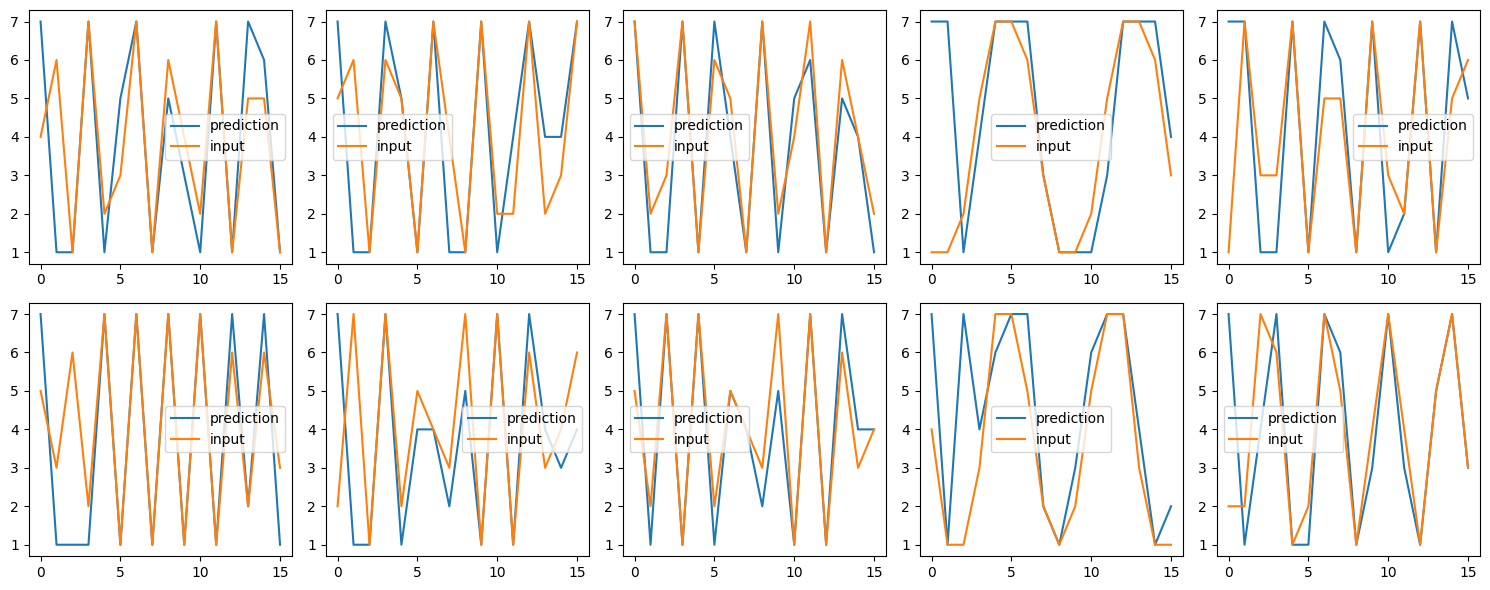

In [26]:
# plot the 10 first examples
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].plot(jnp.argmax(logits, axis=-1)[i], label='prediction')
    # plot the input
    axs[i // 5, i % 5].plot(batch_inputs[i,:,0], label='input')
    axs[i // 5, i % 5].legend()
plt.tight_layout()
plt.show()


In [27]:
# print state

In [28]:
state.params.keys()

dict_keys(['cache', 'params'])

In [29]:
state.params['params'].keys()

dict_keys(['decoder', 'encoder', 'layers_0', 'layers_1', 'layers_2', 'layers_3'])

In [30]:
next(iter(trainloader))[0].shape

torch.Size([128, 16, 1])

In [31]:
print(state.params['params']['encoder']['bias'].shape)
print(state.params['params']['encoder']['kernel'].shape)


(10,)
(1, 10)


In [32]:
print(state.params['params']['layers_0'].keys())

dict_keys(['norm', 'out', 'out2', 'seq'])


In [44]:
print(state.params['params']['layers_0']['norm'].keys())

dict_keys(['bias', 'scale'])


In [45]:
print(state.params['params']['layers_0']['norm']['bias'].shape)
print(state.params['params']['layers_0']['norm']['scale'].shape)

(10,)
(10,)


In [42]:
print(state.params['params']['layers_0']['out'].keys())
print(state.params['params']['layers_0']['out2'].keys())

dict_keys(['bias', 'kernel'])
dict_keys(['bias', 'kernel'])


In [43]:
print(state.params['params']['layers_0']['out']['bias'].shape)
print(state.params['params']['layers_0']['out']['kernel'].shape)
print(state.params['params']['layers_0']['out2']['bias'].shape)
print(state.params['params']['layers_0']['out2']['kernel'].shape)

(10,)
(10, 10)
(10,)
(10, 10)


In [33]:
print(state.params['params']['layers_0']['seq'].keys())

dict_keys(['A', 'B', 'C', 'D', 'log_step'])


In [34]:
print(state.params['params']['layers_0']['seq']['A'].shape)
print(state.params['params']['layers_0']['seq']['B'].shape)
print(state.params['params']['layers_0']['seq']['C'].shape)
print(state.params['params']['layers_0']['seq']['D'].shape)
print(state.params['params']['layers_0']['seq']['log_step'].shape)


(64, 10, 64)
(64, 10, 1)
(1, 10, 64)
(1, 10)
(1, 10)


In [34]:
print(state.params['params']['layers_0']['seq']['A'][0,0,0])
print(state.params['params']['layers_0']['seq']['A'][0,1,0])
print(state.params['params']['layers_0']['seq']['D'][0,0])
print(state.params['params']['layers_0']['seq']['D'][0,1])

0.002715726
-0.053828467
1.1623794
0.8955986


In [35]:
print(state.params['params']['decoder']['bias'].shape)
print(state.params['params']['decoder']['kernel'].shape)

(8,)
(3, 8)


In [54]:
A = 64**2
B = 64
C = 64
D = 1
H = 10
o = 10*10 + 10
o2 = 10*10 + 10
norm = 10 + 10
seq_p = H*(A+B+C+D) + o + o2 + norm
n_lay = 4
enc = 10+10
dec = 10*8+10
cache_x = 128*64*10 * 4
n_p = n_lay * seq_p + enc + dec + cache_x
print(f'{n_p=}')

n_p=497750


In [65]:
n_examples = 1024
SEQ_LENGTH, N_CLASSES, IN_DIM = 16, 8, 1
x = np.linspace(0, 2 * np.pi, num=SEQ_LENGTH)
# jnp.digitize: Return the indices of the bins to which each value in input array belongs.
y = np.digitize(np.sin(x), np.linspace(-1, 1, num=N_CLASSES))

# Tile this `n_examples` times...
# data will be a tensor of shape (n_examples, SEQ_LENGTH, IN_DIM)
data = torch.Tensor(
    np.tile(
        np.expand_dims(np.expand_dims(y, -1), 0), reps=[n_examples, 1, 1]
    )
)
key = jax.random.PRNGKey(0)
key, rng = jax.random.split(key)
amplitudes = jax.random.uniform(rng, shape=(n_examples, 1, 1), minval=0.5, maxval=1.5)
amplitudes = np.array(amplitudes)
data = data * amplitudes


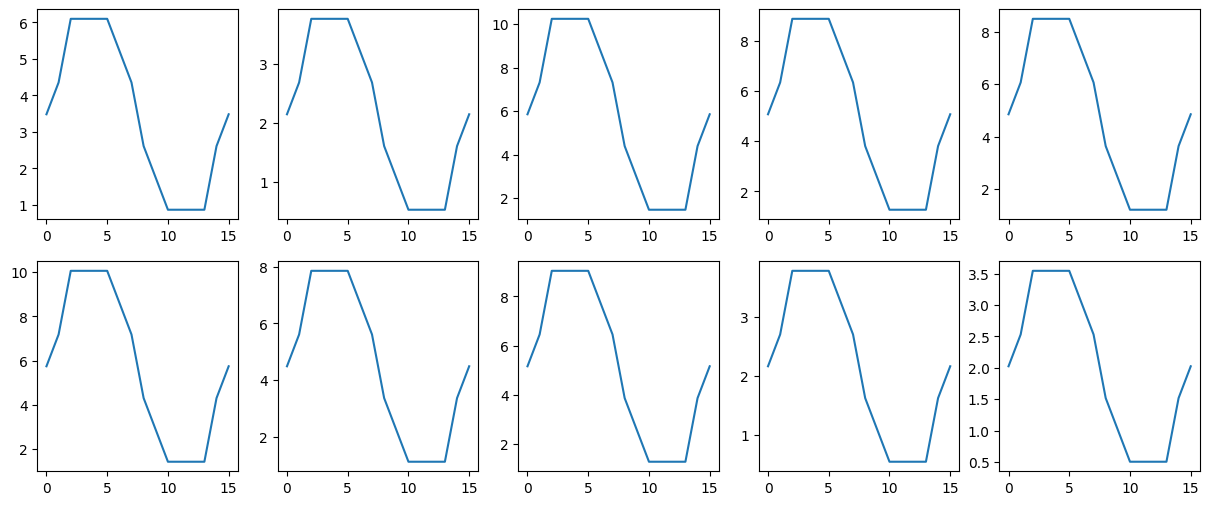

In [66]:
# plot 10 examples
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].plot(data[i,:,0])
plt.show()


In [65]:
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(k_in, nested_dict):
        if k_in != None: print(f'{k_in}', end=' ')
        return {
            k: (map_fn(k, v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }
    
    return map_fn
    
a = map_nested_fn(lambda k, v: print(f'\n {k, v.shape}'))(None, state.params)

cache layers_0 seq 
 ('cache_x_k', (128, 64, 10))
layers_1 seq 
 ('cache_x_k', (128, 64, 10))
layers_2 seq 
 ('cache_x_k', (128, 64, 10))
layers_3 seq 
 ('cache_x_k', (128, 64, 10))
params decoder 
 ('bias', (8,))

 ('kernel', (10, 8))
encoder 
 ('bias', (10,))

 ('kernel', (1, 10))
layers_0 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('D', (1, 10))

 ('log_step', (1, 10))
layers_1 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('D', (1, 10))

 ('log_step', (1, 10))
layers_2 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('

In [57]:
a

{'cache': {'layers_0': {'seq': {'cache_x_k': None}},
  'layers_1': {'seq': {'cache_x_k': None}},
  'layers_2': {'seq': {'cache_x_k': None}},
  'layers_3': {'seq': {'cache_x_k': None}}},
 'params': {'decoder': {'bias': None, 'kernel': None},
  'encoder': {'bias': None, 'kernel': None},
  'layers_0': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_1': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_2': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_3': {'norm': {'bias': None, 'scale': None},
   'out': {'bias':